<a href="https://colab.research.google.com/github/kyook17/UIUC_BADM/blob/main/BADM576_DS/Tree_based_models_Custom_Error_Metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Learning Goals:

1. Tree-based models for Regression Problem
* Regression Tree
* Random Forest Regressor
* Gradient Boosting Regressor
* Extreme Gradient Boosting Regressor (XGB)
* Light Gradient Boosted Machines (LGB)

2. GridSearch CV for HyperParameter Tuning

3. Use Custom Scoring Method for Model Tuning


Some of these models may take up to 4-5 minutes to run.

In [ ]:
#!pip install autoviz

## Importing necessary packages

We will start by importing the necessary packages for data preparation, modeling, and evaluation. The packages we will be using are:

- `pandas` for data handling
- `numpy` for numerical operations
- `train_test_split` for splitting the data into training and testing sets
- `ColumnTransformer` and `Pipeline` for creating a data preprocessing pipeline
- `SimpleImputer` for handling missing values
- `OneHotEncoder` and `OrdinalEncoder` for categorical encoding
- `DecisionTreeRegressor`, `RandomForestRegressor`, `GradientBoostingRegressor`, `XGBRegressor`, and `LGBMRegressor` for modeling
- `GridSearchCV` for hyperparameter tuning
- `mean_squared_error` and `mean_absolute_error` for evaluation
- `time` for timing the code execution
- `AutoViz_Class` for creating a data preparation report

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time
import matplotlib.pyplot as plt
#from autoviz.AutoViz_Class import AutoViz_Class

The dataset is for predicting Laptop's `Retail Price`.

In [ ]:
# Load the dataset
df = pd.read_csv("https://raw.githubusercontent.com/ashish-cell/BADM-211-FA21/main/Data/laptop_hw6.csv")

In [ ]:
df.dropna(inplace = True)

In [ ]:
#from autoviz.AutoViz_Class import AutoViz_Class

In [ ]:
#AV = AutoViz_Class() # Initialize Autoviz_Class

In [ ]:
#AV.AutoViz("", depVar= "Retail_Price",dfte = df, chart_format="html")  # use method AutoViz.

No data cleaning required. However, we have basic pipeline set up as we need to dummy code two categorical features.

In [ ]:
# pipeline for nominal categorical columns
nom_cat_pipe = Pipeline(steps = [("imp", SimpleImputer(strategy= "constant", fill_value = "missing")),
                                 ("ohe", OneHotEncoder(sparse_output=False)),])

In [ ]:
nom_cat_vars = ['Integrated_Wireless', 'Bundled_Applications']

In [ ]:
preprocessor = ColumnTransformer(transformers = [("nom", nom_cat_pipe, nom_cat_vars)], remainder = "passthrough")

preprocessor.set_output(transform = "pandas")

ColumnTransformer(remainder='passthrough',
                  transformers=[('nom',
                                 Pipeline(steps=[('imp',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('ohe',
                                                  OneHotEncoder(sparse_output=False))]),
                                 ['Integrated_Wireless',
                                  'Bundled_Applications'])])

In [ ]:
X = df.drop(columns = ["Transaction_ID", "Retail_Price"]) # drop Transaction ID and Retail Price
y = df["Retail_Price"]

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
train_X.shape

(4536, 8)

### Decision Trees
- Decision Trees are simple and powerful non-parametric models that can be used for both classification and regression tasks.
- They learn a hierarchy of if-then-else decision rules that can be easily interpreted and visualized.
- They can handle both numerical and categorical data, and can also handle missing values through appropriate imputation.
- However, Decision Trees are prone to overfitting, especially when the tree is deep and complex. They also suffer from instability due to small variations in the data.
- To address these issues, ensemble methods such as Random Forests and Gradient Boosting are often used.


In [ ]:
# Define the Decision Tree model pipeline
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])


In the code above, a decision tree model pipeline is defined using `Pipeline` from `sklearn.pipeline`. The pipeline includes a preprocessor step and a decision tree model step.

In [ ]:
# Define the parameter grid for the Decision Tree model
dt_param_grid = {
    'model__max_depth': [None, 5, 10, 15, 20],
    'model__min_samples_split': [2, 5, 10, 20, 30],
    'model__min_samples_leaf': [1, 2, 4, 8],
    #'model__max_features': ['1.0', 'sqrt', 'log2', None], # generally useful for random forest.
    #'model__criterion': ['friedman_mse', 'squared_error', 'absolute_error']
}

- `model__max_depth`: This parameter controls the maximum depth of the decision tree. If set to None, the tree is allowed to grow until all leaves are pure, meaning they contain only samples from one class. Setting a maximum depth helps prevent overfitting and can improve generalization performance.

- `model__min_samples_split`: This parameter controls the minimum number of samples required to split an internal node. If the number of samples in a node is less than this value, the node will not be split further. Setting a higher value can help prevent overfitting by ensuring that each split is based on a sufficient number of samples.

- `model__min_samples_leaf`: This parameter controls the minimum number of samples required to be at a leaf node. If the number of samples at a leaf node is less than this value, the node will be discarded as too specific. Setting a higher value can help prevent overfitting by requiring each leaf to be based on a sufficient number of samples.

- `model__max_features`: This parameter controls the number of features considered when splitting a node. The value can be an integer (representing the number of features) or a float (representing a fraction of the total number of features). Setting a lower value can help prevent overfitting by forcing the model to consider a smaller subset of features.

- `model__criterion`: This parameter determines the function used to measure the quality of a split.


Note that each hyperparameter name is prefixed with 'model__'. This is because the GridSearchCV function expects the hyperparameters to be specified as part of a pipeline, which includes the DecisionTree model as one of its components. The prefix indicates that the hyperparameters should be applied to the DecisionTree model specifically, rather than to the entire pipeline.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

start_time = time.time()

# Perform grid search for the Decision Tree model
dt_grid_search = GridSearchCV(estimator=dt_pipeline, param_grid=dt_param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
dt_grid_search.fit(train_X, train_y)

# Fit the best Decision Tree model
dt_model = dt_grid_search.best_estimator_
dt_model.fit(train_X, train_y)

# Evaluate the Decision Tree model on the test data
dt_pred = dt_model.predict(test_X)
dt_rmse = mean_squared_error(test_y, dt_pred, squared=False)
dt_mae = mean_absolute_error(test_y, dt_pred)

print(f"Decision Tree RMSE: {dt_rmse:.2f}")
print(f"Decision Tree MAE: {dt_mae:.2f}")

end_time = time.time()
print("Time taken:", end_time - start_time, "seconds")

Decision Tree RMSE: 49.05
Decision Tree MAE: 32.00
Time taken: 17.331065893173218 seconds


Explanation of code

- **`mean_squared_error()`** and **`mean_absolute_error()`** are two built-in functions in `sklearn.metrics` module that are used to calculate the mean squared error and mean absolute error, respectively.

- **`start_time = time.time()`** creates a variable that stores the current time.

- **`GridSearchCV()`** is a function from `sklearn.model_selection` module that performs a grid search on the parameter grid defined in `dt_param_grid`.

- **`fit()`** fits the `dt_grid_search` object to the training data.

- **`best_estimator_`** returns the best estimator found by the grid search.

- **`predict()`** predicts the target values for the test data.

- **`dt_rmse`** stores the root mean squared error calculated using `mean_squared_error()`.

- **`dt_mae`** stores the mean absolute error calculated using `mean_absolute_error()`.

- **`end_time = time.time()`** creates a variable that stores the current time.



# Feature Importance

In machine learning, **feature importance** refers to a technique used to evaluate which features or variables are most relevant in predicting the target variable.

For decision tree-based models, feature importance is calculated based on how much the tree nodes that use a particular feature reduce impurity on average over all trees in the ensemble. The higher the reduction in impurity, the more important the feature is considered to be.

There are several ways to evaluate feature importance, but one common method is to use the **Gini importance**, which is calculated by summing the reduction in impurity of each node that uses the feature. Another method is the **permutation importance**, which randomly shuffles the values of a feature and measures how much the performance of the model decreases as a result.

In the code provided, the feature importances are calculated using the feature_importances_ attribute of the decision tree model. The resulting values are then sorted and plotted using matplotlib to visualize the relative importance of each feature in predicting the target variable.

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


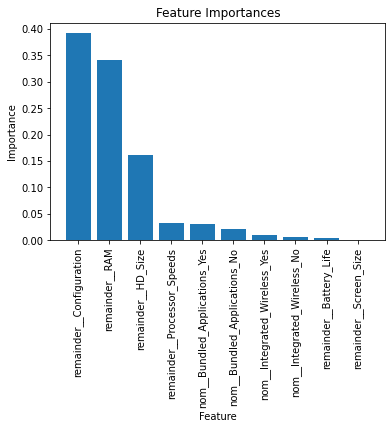

In [ ]:
importances = dt_model.named_steps['model'].feature_importances_

feature_importances = pd.DataFrame({'feature': dt_model[:-1].get_feature_names_out(), 'importance': importances})

# Sort the DataFrame in descending order of feature importances
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Plot the feature importances using matplotlib
plt.bar(x=feature_importances['feature'], height=feature_importances['importance'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

- `importances = dt_model.named_steps['model'].feature_importances_` calculates the feature importances of the trained Decision Tree model.

- `pd.DataFrame()` creates a new pandas DataFrame object to store the feature importances along with their corresponding feature names.

- `dt_model[:-1].get_feature_names_out()` returns the names of the features in the preprocessed training data.

- `sort_values()` is a method of pandas DataFrame object that sorts the DataFrame in descending order of the feature importances.

- `plt.bar()` is a function from the matplotlib library that creates a bar plot to visualize the feature importances.

- `plt.xticks()` sets the labels of the x-axis of the plot to the feature names.

- `plt.xlabel()`, `plt.ylabel()`, and `plt.title()` set the labels and title of the plot.

- `plt.show()` displays the plot on the screen.

**SHAP** values are a method for explaining the output of any machine learning model. SHAP stands for ***SHapley Additive exPlanations***, and is based on a concept from cooperative game theory called the Shapley value. The SHAP value for a feature is the contribution of that feature towards the prediction of a certain output for a specific instance.

SHAP values can help us understand which features are most important for a model's prediction, and how much each feature contributes to that prediction.


The SHAP library is a Python library that implements the SHAP values method for explaining machine learning models.

In [ ]:
!pip install shap

In [ ]:
import shap

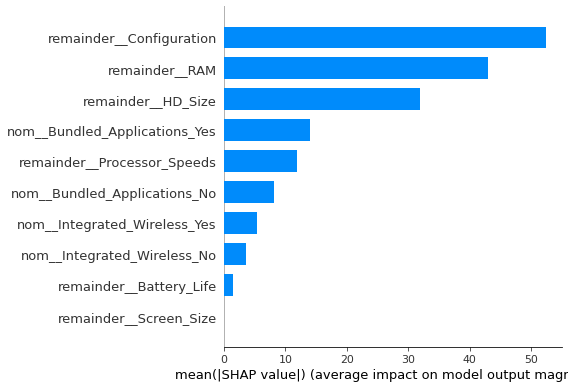

In [ ]:



# Create an explainer object for the random forest model

train_X_transformed = dt_model.named_steps['preprocessor'].transform(train_X)

explainer = shap.Explainer(dt_model.named_steps['model'], train_X_transformed, feature_names=dt_model[:-1].get_feature_names_out())

# Compute SHAP values for the test set
test_X_transformed = dt_model.named_steps['preprocessor'].transform(test_X)
shap_values = explainer(test_X_transformed)

fig = plt.figure(figsize=(16, 16))
# Plot the SHAP summary plot
shap.summary_plot(shap_values, test_X_transformed, plot_type='bar')


### Random Forests
- Random Forests are ensemble methods that combine multiple Decision Trees to improve performance and reduce overfitting.
- They randomly select a subset of features and data points for each tree, and then average the predictions across all trees.
- They can handle large and complex datasets, and can automatically detect interactions and nonlinear relationships between features.
- However, they can be computationally expensive and difficult to interpret compared to a single Decision Tree.


List of all Hyperparameters. We only tune a few. These are for reference.

| Parameter Name           | Description                                                                                                                                                                    | Overfitting Impact                                                                                                           |
|--------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------|
| bootstrap                | Whether bootstrap samples are used when building decision trees.                                                                                                              | Setting `bootstrap` to `True` (the default) may increase the risk of overfitting if the trees are allowed to grow too deep. |
| ccp_alpha                | The complexity parameter used for cost complexity pruning in decision trees.                                                                                                   | Increasing `ccp_alpha` can help prevent overfitting by encouraging the tree to be smaller and less complex.                |
| criterion                | The measure of impurity used to split nodes in decision trees. The default is `'mse'` (mean squared error).                                                                     | Changing the criterion can affect the shape of the tree and may influence overfitting.                                      |
| max_depth                | The maximum depth of each decision tree.                                                                                                                                       | Increasing `max_depth` can lead to overfitting by allowing the tree to become too complex and fit the noise in the training data. |
| max_features             | The maximum number of features considered when splitting nodes in decision trees.                                                                                             | Reducing `max_features` can help prevent overfitting by focusing on the most informative features.                            |
| max_leaf_nodes           | The maximum number of leaf nodes in each decision tree.                                                                                                                       | Increasing `max_leaf_nodes` can help prevent overfitting by limiting the size of the tree and reducing its complexity.        |
| max_samples              | The maximum number of samples used to train each decision tree.                                                                                                               | Reducing `max_samples` can help prevent overfitting by limiting the amount of data used to train each tree.                  |
| min_impurity_decrease    | The minimum impurity decrease required to split a node in decision trees.                                                                                                     | Increasing `min_impurity_decrease` can help prevent overfitting by reducing the number of splits and limiting the complexity of the tree. |
| min_samples_leaf         | The minimum number of samples required to be in a leaf node in decision trees.                                                                                                | Increasing `min_samples_leaf` can help prevent overfitting by forcing the tree to have more generalizable splits.              |
| min_samples_split        | The minimum number of samples required to split an internal node in decision trees.                                                                                           | Increasing `min_samples_split` can help prevent overfitting by reducing the number of splits and limiting the complexity of the tree. |
| min_weight_fraction_leaf | The minimum fraction of the total weight of the input samples required to be in a leaf node in decision trees.                                                               | Increasing `min_weight_fraction_leaf` can help prevent overfitting by forcing the tree to have more generalizable splits.         |
| n_estimators             | The number of decision trees in the random forest model.                                                                                                                      | Increasing the number of trees can improve the model's performance, but it also increases the risk of overfitting, especially if the trees are allowed to grow too deep. |
| n_jobs                   | The number of parallel jobs used for fitting and predicting.                                                                                                                  | Increasing `n_jobs` can speed up the training and prediction process, but it does not directly affect overfitting.             |
| oob_score                | Whether out-of-bag (OOB) samples are used to estimate the generalization error of the model.                                                                                    | Setting `oob_score` to `True` can provide an estimate of the model's performance on new data, but it does not directly affect overfitting. |



In [ ]:
start_time = time.time()

# Define the Random Forest model pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

# Define the parameter grid for the Random Forest model
rf_param_grid = {
    'model__n_estimators': [50, 100, 150, 200], # This is the parameter that defines the number of Trees in the Forest.
    'model__max_depth': [None, 5, 10, 15, 20],
    'model__min_samples_split': [2, 5, 10, 20, 30],
}

# Perform grid search for the Random Forest model
rf_grid_search = GridSearchCV(estimator = rf_pipeline, param_grid = rf_param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
rf_grid_search.fit(train_X, train_y)

# Fit the best Random Forest model
rf_model = rf_grid_search.best_estimator_
rf_model.fit(train_X, train_y)

# Evaluate the Random Forest model on the test data
rf_pred = rf_model.predict(test_X)
rf_rmse = np.sqrt(mean_squared_error(test_y, rf_pred))
rf_mae = mean_absolute_error(test_y, rf_pred)

print(f"Random Forest RMSE: {rf_rmse:.2f}")
print(f"Random Forest MAE: {rf_mae:.2f}")

end_time = time.time()

print("Time taken:", end_time - start_time, "seconds")

Random Forest RMSE: 47.83
Random Forest MAE: 30.77
Time taken: 295.7739624977112 seconds


###Feature Importance



In [ ]:
importances =  rf_model.named_steps['model'].feature_importances_

In [ ]:
# Print the feature importances
for feature, importance in zip(rf_model[:-1].get_feature_names_out(), importances):
    print(feature, importance)

nom__Integrated_Wireless_No 0.005264427231687022
nom__Integrated_Wireless_Yes 0.005435077375644284
nom__Bundled_Applications_No 0.02632432667874336
nom__Bundled_Applications_Yes 0.025655671558078685
remainder__Configuration 0.4014894370341846
remainder__Screen_Size 9.984125447205349e-05
remainder__Battery_Life 0.0020087848298651406
remainder__RAM 0.341508484901461
remainder__Processor_Speeds 0.033513938708713484
remainder__HD_Size 0.15870001042715046


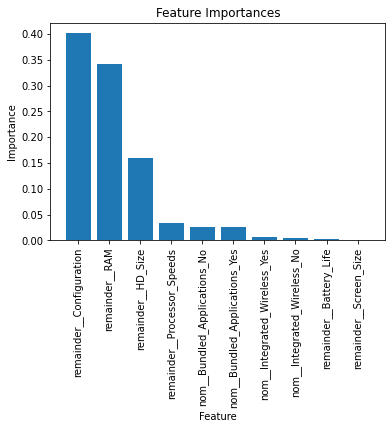

In [ ]:
feature_importances = pd.DataFrame({'feature': rf_model[:-1].get_feature_names_out(), 'importance': importances})

# Sort the DataFrame in descending order of feature importances
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Plot the feature importances using matplotlib
plt.bar(x=feature_importances['feature'], height=feature_importances['importance'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

`rf_model[:-1].get_feature_names_out()` I used this to extract the fetaure names after the column transformer worked

 97%|=================== | 1104/1134 [00:34<00:00]       

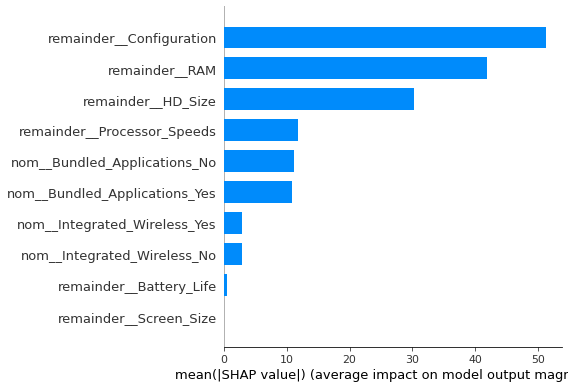

In [ ]:
import shap

# Create an explainer object for the random forest model

train_X_transformed = rf_model.named_steps['preprocessor'].transform(train_X)

explainer = shap.Explainer(rf_model.named_steps['model'], train_X_transformed, feature_names=rf_model[:-1].get_feature_names_out())

# Compute SHAP values for the test set
test_X_transformed = rf_model.named_steps['preprocessor'].transform(test_X)
shap_values = explainer(test_X_transformed)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, test_X_transformed, plot_type='bar')

### Gradient Boosting
- Gradient Boosting is another ensemble method that combines multiple weak learners (e.g., shallow Decision Trees) to create a strong learner.
- It builds the model in a forward stage-wise manner by optimizing a differentiable loss function at each stage.
- It can handle both numerical and categorical data, and can automatically detect interactions and nonlinear relationships between features.
- It can also handle missing data and outliers, and can achieve high performance with relatively few hyperparameters.
- However, it can be prone to overfitting, especially when the model is too complex or the learning rate is too high.

A list of parameters that are available for boosting models. These are over and above the ones used in Random Forest.

| Parameter Name   | Description                                                                                                                                                  | Overfitting Impact                                                                                                           |
|------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------|
| learning_rate  | The learning rate or shrinkage parameter.                                                                                                                    | Lower values of `learning_rate` can help prevent overfitting by slowing down the learning process.                           |
| subsample      | The fraction of samples used for each boosting stage.                                                                                                         | Reducing `subsample` can help prevent overfitting by introducing more randomness into the model.                               |
| max_features   | The maximum number of features considered when splitting nodes.                                                                                               | Reducing `max_features` can help prevent overfitting by focusing on the most informative features.                            |
| alpha          | The L1 regularization parameter.                                                                                                                             | Increasing `alpha` can help prevent overfitting by encouraging sparsity in the model.                                        |
| beta           | The L2 regularization parameter.                                                                                                                             | Increasing `beta` can help prevent overfitting by encouraging small weights in the model.                                     |
| warm_start     | Whether to reuse the solution of the previous call to fit as initialization.                                                                                 | Setting `warm_start` to `True` can help prevent overfitting by allowing the model to continue training from its previous state. |
| tol            | The tolerance for stopping criterion.                                                                                                                         | Lower values of `tol` can help prevent overfitting by stopping the model training earlier.                                   |
| validation_fraction | The fraction of training data to set aside as validation set for early stopping.                                                                             | Using early stopping with a validation set can help prevent overfitting by stopping the model training earlier.              |
| n_iter_no_change | The number of boosting iterations with no improvement before stopping the model training.                                                                    | Using early stopping with a stopping criterion can help prevent overfitting by stopping the model training earlier.          |

In [ ]:
start_time = time.time()

# Define the Gradient Boosting model pipeline
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(random_state=42))

])

gb_param_grid = {
    'model__n_estimators': [50, 100, 150, 200], # This is the parameter that defines the number of Trees in the Forest.
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 5, 7, 9],
    'model__min_samples_split': [2, 5, 10],
}

# Perform grid search for the Gradient Boosting model
gb_grid_search = GridSearchCV(estimator = gb_pipeline, param_grid = gb_param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
gb_grid_search.fit(train_X, train_y)

# Fit the best Gradient Boosting model
gb_model = gb_grid_search.best_estimator_
gb_model.fit(train_X, train_y)

# Evaluate the Gradient Boosting model on the test data
gb_pred = gb_model.predict(test_X)
gb_rmse = np.sqrt(mean_squared_error(test_y, gb_pred))
gb_mae = mean_absolute_error(test_y, gb_pred)

print(f"Gradient Boosting RMSE: {gb_rmse:.2f}")
print(f"Gradient Boosting MAE: {gb_mae:.2f}")

end_time = time.time()

print("Time taken:", end_time - start_time, "seconds")

Gradient Boosting RMSE: 47.33
Gradient Boosting MAE: 30.17
Time taken: 326.22152638435364 seconds


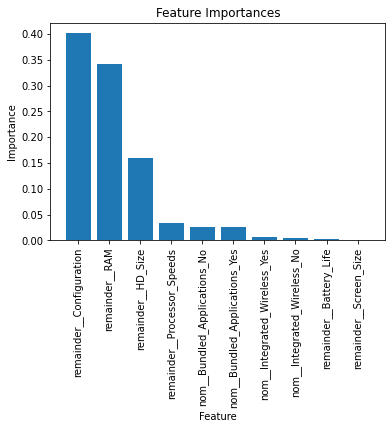

In [ ]:
importances = gb_model.named_steps['model'].feature_importances_

# Sort the DataFrame in descending order of feature importances
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Plot the feature importances using matplotlib
plt.bar(x=feature_importances['feature'], height=feature_importances['importance'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

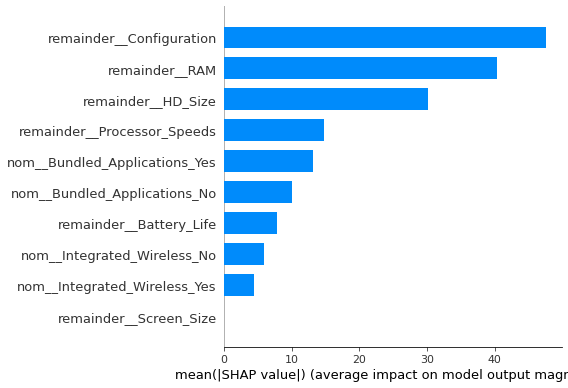

In [ ]:
# Create an explainer object for the random forest model

train_X_transformed = gb_model.named_steps['preprocessor'].transform(train_X)

explainer = shap.Explainer(gb_model.named_steps['model'], train_X_transformed, feature_names=gb_model[:-1].get_feature_names_out())

# Compute SHAP values for the test set
test_X_transformed = gb_model.named_steps['preprocessor'].transform(test_X)
shap_values = explainer(test_X_transformed)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, test_X_transformed, plot_type='bar')

### XGBoost
- XGBoost is an optimized and scalable implementation of Gradient Boosting that uses a more regularized and parallelized approach.
- It has several advanced features such as tree pruning, column subsampling, and weighted quantile sketching to improve performance and reduce overfitting.

In [ ]:
start_time = time.time()

# Define the XGB model pipeline
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=42))
])

# Define the parameter grid for the XGB model
xgb_param_grid = {
    'model__n_estimators': [50, 100, 150, 200],
    'model__max_depth': [3, 5, 7, 9],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.5],
    'model__subsample': [0.5, 0.75, 1],
}

# Perform grid search for the XGB model
xgb_grid_search = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
xgb_grid_search.fit(train_X, train_y)

# Fit the best XGB model
xgb_model = xgb_grid_search.best_estimator_
xgb_model.fit(train_X, train_y)

# Evaluate the XGB model on the test data
xgb_pred = xgb_model.predict(test_X)
xgb_rmse = np.sqrt(mean_squared_error(test_y, xgb_pred))
xgb_mae = mean_absolute_error(test_y, xgb_pred)

print(f"XGB RMSE: {xgb_rmse:.2f}")
print(f"XGB MAE: {xgb_mae:.2f}")

end_time = time.time()

print("Time taken:", end_time - start_time, "seconds")

XGB RMSE: 46.99
XGB MAE: 29.58
Time taken: 368.2853546142578 seconds


**The xgb_param_grid** dictionary defines a grid of hyperparameters to be tuned for an XGBoost model using scikit-learn's GridSearchCV function. Each key in the dictionary corresponds to a hyperparameter, and the corresponding value is a list of possible values for that hyperparameter. Here's a brief explanation of each hyperparameter:

**model__n_estimators**: The number of trees (estimators) in the XGBoost model. Increasing this value generally improves the model's performance, but can also increase the risk of overfitting.

**model__max_depth**: The maximum depth of each tree in the XGBoost model. Increasing this value can improve the model's performance, but can also increase the risk of overfitting.

**model__learning_rate**: The learning rate, or step size, used when updating the weights of the XGBoost model. Lower values generally result in a more accurate model, but can also require more iterations to converge.

**model__subsample**: The fraction of the training data to be randomly sampled for each tree in the XGBoost model. This can help prevent overfitting and improve the model's generalization performance.



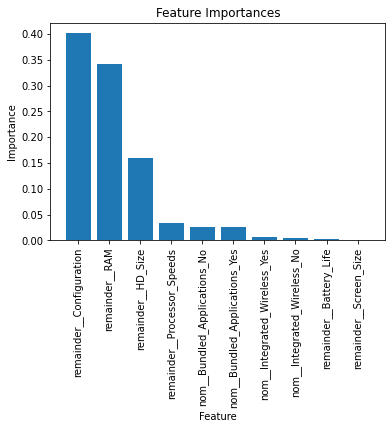

In [ ]:
importances = xgb_model.named_steps['model'].feature_importances_

# Sort the DataFrame in descending order of feature importances
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Plot the feature importances using matplotlib
plt.bar(x=feature_importances['feature'], height=feature_importances['importance'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

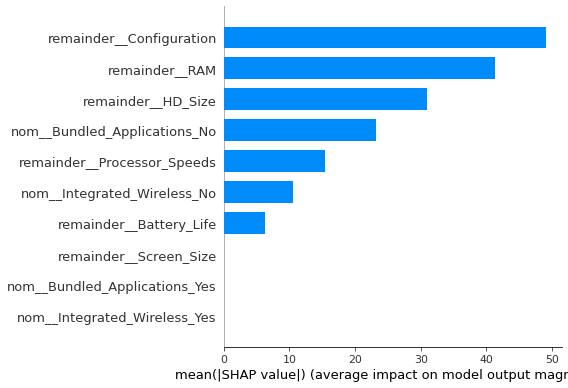

In [ ]:
# Create an explainer object for the random forest model

train_X_transformed = xgb_model.named_steps['preprocessor'].transform(train_X)

explainer = shap.Explainer(xgb_model.named_steps['model'], train_X_transformed, feature_names=xgb_model[:-1].get_feature_names_out())

# Compute SHAP values for the test set
test_X_transformed = xgb_model.named_steps['preprocessor'].transform(test_X)
shap_values = explainer(test_X_transformed)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, test_X_transformed, plot_type='bar')

### LightGBM
- LightGBM is another optimized and scalable implementation of Gradient Boosting that uses a similar approach as XGBoost but with some different features and optimizations.
- It uses a histogram-based approach to bin continuous features and optimize the split points, which can be much faster and more memory-efficient than traditional tree-based methods.
- It also supports GPU acceleration and distributed computing, which can further improve performance on large and complex datasets.
- It can achieve state-of-the-art performance on many benchmarks.

In [ ]:
start_time = time.time()

# Define the Light GBM model pipeline
lgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(random_state=42))
])

# Define the parameter grid for the Light GBM model
lgb_param_grid = {
    'model__n_estimators': [50, 100, 150, 200],
    'model__max_depth': [3, 5, 7, 9],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.5],
    'model__subsample': [0.5, 0.75, 1],
}

# Perform grid search for the Light GBM model
lgb_grid_search = GridSearchCV(lgb_pipeline, lgb_param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
lgb_grid_search.fit(train_X, train_y)

# Fit the best Light GBM model
lgb_model = lgb_grid_search.best_estimator_
lgb_model.fit(train_X, train_y)

# Evaluate the Light GBM model on the test data
lgb_pred = lgb_model.predict(test_X)
lgb_rmse = np.sqrt(mean_squared_error(test_y, lgb_pred))

lgb_mae = mean_absolute_error(test_y, lgb_pred)

end_time = time.time()

print("Time taken:", end_time - start_time, "seconds")

Time taken: 85.44569611549377 seconds


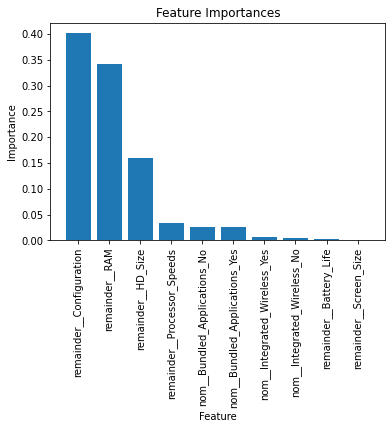

In [ ]:
importances = lgb_model.named_steps['model'].feature_importances_

# Sort the DataFrame in descending order of feature importances
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Plot the feature importances using matplotlib
plt.bar(x=feature_importances['feature'], height=feature_importances['importance'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

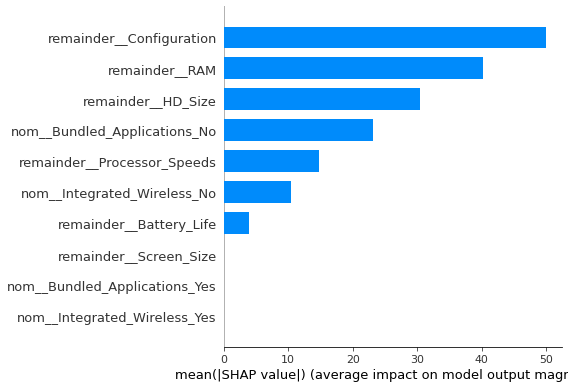

In [ ]:
# Create an explainer object for the random forest model

train_X_transformed = lgb_model.named_steps['preprocessor'].transform(train_X)

explainer = shap.Explainer(lgb_model.named_steps['model'], train_X_transformed, feature_names=gb_model[:-1].get_feature_names_out())

# Compute SHAP values for the test set
test_X_transformed = lgb_model.named_steps['preprocessor'].transform(test_X)
shap_values = explainer(test_X_transformed)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, test_X_transformed, plot_type='bar')

## Compare the performances of all models

- **models** is a list of strings that contains the names of all models that were evaluated.
- **rmse_scores** is a list of floating point values that contains the root mean squared error (RMSE) for each model.
- **mae_scores** is a list of floating point values that contains the mean absolute error (MAE) for each model.
- **results_df** is a Pandas DataFrame that stores the RMSE and MAE scores for each model in a table.
- **print(results_df)** displays the table of RMSE and MAE scores for each model.

In [ ]:
# Compare the performances of all models
models = ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGB', 'Light GBM']
rmse_scores = [dt_rmse, rf_rmse, gb_rmse, xgb_rmse, lgb_rmse]
mae_scores = [dt_mae, rf_mae, gb_mae, xgb_mae, lgb_mae]

results_df = pd.DataFrame({'Model': models, 'RMSE': rmse_scores, 'MAE': mae_scores})
print(results_df)



               Model       RMSE        MAE
0      Decision Tree  49.047268  32.003098
1      Random Forest  47.828354  30.765693
2  Gradient Boosting  47.331916  30.167430
3                XGB  46.989945  29.578707
4          Light GBM  46.926323  29.880135


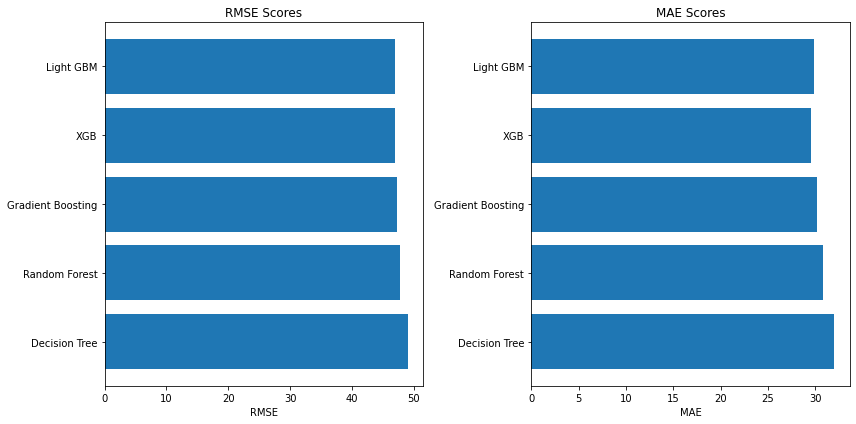

In [ ]:
# Visualize the evaluation metrics across all models
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.barh(models, rmse_scores)
plt.title('RMSE Scores')
plt.xlabel('RMSE')

plt.subplot(122)
plt.barh(models, mae_scores)
plt.title('MAE Scores')
plt.xlabel('MAE')

plt.tight_layout()
plt.show()

As we see above, the models are shown with their performance on the two metrics.



# Defining Custom Error Metric

In some cases, the cost of making an overprediction can be much higher or lower than than the cost of making an underprediction.

**1. Underprediction is costlier than Overprediction**
For example, in a manufacturing process, if a machine is predicted to produce 10 units in an hour but actually produces 12, it may result in a wastage of resources and increase in production costs. On the other hand, if the machine is predicted to produce 12 units but actually produces 10, it may lead to a temporary shortage of inventory, which may not have as severe consequences. In such cases, a custom error metric that gives more weightage to overpredictions can be used to ensure that the model is optimized for the specific business needs.


**2. Overprediction is costlier than Underprediction**

Let's consider the example of predicting housing prices. In some cases, overpredicting the price of a house can be more costly than underpredicting.

For instance, suppose a real estate company has a policy of buying houses at the predicted price and then selling them at a markup. If the company overpredicts the price of a house, they may end up buying it at a higher price than the market value and then struggle to sell it at a profit. On the other hand, if they underpredict the price, they may miss out on a potentially profitable investment opportunity. In this case, a custom error metric that places more weight on overprediction than underprediction would be more appropriate.

In [ ]:
from sklearn.metrics import make_scorer
import numpy as np

# Define the custom error function
def custom_error(y_true, y_pred):
    diff = y_pred - y_true
    error = np.where(diff > 0, diff, 2 * diff)
    return np.mean(error)

# Convert the custom error function into a scorer object
custom_scorer = make_scorer(custom_error, greater_is_better=False)

# Perform grid search for the Decision Tree model using the custom error function
dt_grid_search = GridSearchCV(estimator=dt_pipeline, param_grid=dt_param_grid, cv=5, n_jobs=-1, scoring=custom_scorer)
dt_grid_search.fit(train_X, train_y)

# Fit the best Decision Tree model
dt_model = dt_grid_search.best_estimator_
dt_model.fit(train_X, train_y)

# Evaluate the Decision Tree model on the test data using the custom error function
dt_pred = dt_model.predict(test_X)
dt_error = custom_error(test_y, dt_pred)

print(f"Decision Tree Error: {dt_error:.2f}")

Decision Tree Error: -23.20


In this example, the `custom_error()` function takes two arguments, `y_true` and `y_pred`, which are the true and predicted target values, respectively.

The function first calculates the difference between the predicted and true values (diff), and then assigns a weight of 2 to under-predictions and 1 to over-predictions (error). Finally, the function returns the mean of the weighted errors.

The `make_scorer()` function is used to convert the custom error function into a scorer object that can be passed to the scoring parameter of the grid search. The `greater_is_better` parameter is set to False to indicate that lower error values are better.

The grid search is then performed using the `custom error` function as the `scoring metric`. The best estimator is fitted to the training data, and the error is calculated on the test data using the custom error function.

Note that the custom error function can be defined to assign different weights to over- and under-predictions, depending on the specific requirements of the problem.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor


In [ ]:

# Define the KNN model
knn_model = make_pipeline(StandardScaler(), KNeighborsClassifier())

# Define the hyperparameters to tune
hyperparameters = {'kneighborsclassifier__n_neighbors': range(1, 31)}

# Define the GridSearchCV object
knn_grid_search = GridSearchCV(knn_model, hyperparameters, cv=5, scoring='roc_auc')

# Fit the GridSearchCV object to the training data
knn_grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding AUC score
print('Best hyperparameters:', knn_grid_search.best_params_)
print('Best AUC score:', knn_grid_search.best_score_)

# Get the predicted probabilities on the test set
y_prob = knn_grid_search.best_estimator_.predict_proba(X_test)[:, 1]

# Plot the precision-recall curve
plot_precision_recall_curve(knn_grid_search.best_estimator_, X_test, y_test)
plt.title('Precision-Recall Curve')
plt.show()

# Plot the ROC curve
plot_roc_curve(knn_grid_search.best_estimator_, X_test, y_test)
plt.title('ROC Curve')
plt.show()


In [ ]:
# Define the Light GBM model pipeline
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', KNeighborsRegressor(n_neighbors=4))
])

# Define the parameter grid for the Light GBM model
knn_param_grid = {
    'kneighborsclassifier__n_neighbors': range(1, 31)
}

In [ ]:
start_time = time.time()

# Perform grid search for the knn model
#knn_grid_search = GridSearchCV(knn_pipeline, knn_param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
#knn_grid_search.fit(train_X, train_y)

knn_model = knn_pipeline.fit(train_X, train_y)
# Fit the best knn model
#knn_model = knn_grid_search.best_estimator_
#knn_model.fit(train_X, train_y)

# Evaluate the Light GBM model on the test data
knn_pred = knn_model.predict(test_X)
knn_rmse = np.sqrt(mean_squared_error(test_y, knn_pred))

knn_mae = mean_absolute_error(test_y, knn_pred)

end_time = time.time()

print("Time taken:", end_time - start_time, "seconds")

Time taken: 0.139174222946167 seconds


In [ ]:
knn_pred = knn_model.predict(test_X)
knn_rmse = np.sqrt(mean_squared_error(test_y, knn_pred))

print(f"KNN Tree Error: {knn_rmse:.2f}")

KNN Tree Error: 51.06


In [ ]:
knn_pred_train = knn_model.predict(train_X)
knn_rmse = np.sqrt(mean_squared_error(train_y, knn_pred_train))

print(f"KNN Tree Error: {knn_rmse:.2f}")

KNN Tree Error: 46.29
